In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import investpy

In [12]:
df=investpy.get_stock_historical_data(stock='CIH', country='morocco', from_date='01/01/2022', to_date='01/07/2022')

In [14]:
def momentum(df,w,wsig=9):
	"""
	Momentum
	Inputs: 
	        Input  | Type                             | Description
	       =========================================================================================
	         df    |pandas.DataFrame                  | Prices, volumes .....
	         w     |int                               | The period 
	         wsig* |int                               | The period of the signal line 
	    * By default wsig= 9
	Outputs:
	        Output | Type                             | Description
	       ========================================================================================
	               | pandas.DataFrame (3 columns)     | 1st column: The input
	               |                                  | 2nd column(MOM): Momentums
	               |                                  | 3rd column(MOMsignal) : The signal line 
	"""
	MOM=pd.Series(df.diff(w),name="MOM")
	MOMsignal=pd.Series(MOM.rolling(wsig, min_periods=wsig).mean(), name= "MOMsignal")
	df=pd.DataFrame(df)
	df=df.join(MOM)
	df=df.join(MOMsignal)
	return df

In [28]:
def sign_momentum(df,w,wsig=9):
	MOM=momentum(df,w,wsig)[["MOM","MOMsignal"]]
	print(MOM)
	signal=pd.DataFrame(index=df.index)
	signal["compa"]=np.nan
	signal["compa"][w:]=np.where(MOM["MOM"][w:] > MOM["MOMsignal"][w:],1,0)
	signal["signal"]=adjustsignal(signal["compa"].diff())
	print(signal)
	signal.plot()
	pmval=pmv(df,signal["signal"])
	pmval=pd.Series(pmval,index=df.index)
	fig = plt.figure()
	ax1 = fig.add_subplot(311, ylabel='COURS_CLOTURE')
	df.plot(ax=ax1, color='k', lw=.5, figsize=(13,9))
	ax1.plot(signal.loc[signal.signal== 1.0].index ,df[signal.signal == 1.0],'^', markersize=7, color='g')
	
	ax1.plot(signal.loc[signal.signal== -1].index,df[signal.signal == -1.0], 'v', markersize=7, color='r')
	plt.legend(["COURS_CLOTURE","Achat","Vente"])
	ax2=fig.add_subplot(312, ylabel='MOM')
	MOM.plot(ax=ax2, legend=True, grid=True)
	plt.title("MOM Strategy")
	ax3=fig.add_subplot(313, ylabel='PMV')
	ax3.fill_between(df.index,pmval,where=(pmval > 0), facecolor='green', alpha=0.5)
	ax3.fill_between(df.index,pmval,where=(pmval < 0), facecolor='red',alpha=0.5)
	plt.legend(["Plus_value","Moins_value"])
	plt.show()
	# plt.savefig('books_read.png')
	# return fig


In [25]:
def pmv(close,signal):
	"""
		La Plus-ou-moins-value
	"""
	close=np.array(close)
	signal=np.array(signal.fillna(0))
	qt=signal.cumsum()
	achat= np.where(signal>=1,1,0)
	PDR=[]
	for t in range(len(close)):
		p=(close[:t+1]*achat[:t+1]).sum()
		if achat[:t+1].sum()==0 :
			val=0
		else :
			p=p/(achat[:t+1].sum())
			val=qt[t]*p 
		PDR.append(val)
	PMV_lat=close*qt-PDR
	PMV_re=[0]
	for i in range(1,len(close)):
		vl=PDR[i]-PDR[i-1]+PMV_re[i-1]-close[i]*signal[i]
		PMV_re.append(vl)
	PMV=PMV_lat+PMV_re
	return PMV

In [30]:
def adjustsignal(signal):
	sig=[]
	qtite=0
	for i in signal:
		if i > 0 :
			sig.append(i)
			qtite+=1
		elif i < 0:
			if qtite >= abs(i) :
				sig.append(i)
				qtite+=-i
			else:
				sig.append(0)
		else:
			sig.append(0)
	return sig

             MOM  MOMsignal
Date                       
2022-01-05   NaN        NaN
2022-01-06   NaN        NaN
2022-01-07   NaN        NaN
2022-01-10   NaN        NaN
2022-01-12   NaN        NaN
...          ...        ...
2022-06-23 -20.0  -8.055556
2022-06-24   0.0  -7.833333
2022-06-28   5.0  -8.272222
2022-06-30  -2.0  -6.827778
2022-07-01 -10.0  -7.272222

[112 rows x 2 columns]
            compa  signal
Date                     
2022-01-05    NaN     0.0
2022-01-06    NaN     0.0
2022-01-07    NaN     0.0
2022-01-10    NaN     0.0
2022-01-12    NaN     0.0
...           ...     ...
2022-06-23    0.0     0.0
2022-06-24    1.0     1.0
2022-06-28    1.0     0.0
2022-06-30    1.0     0.0
2022-07-01    0.0    -1.0

[112 rows x 2 columns]


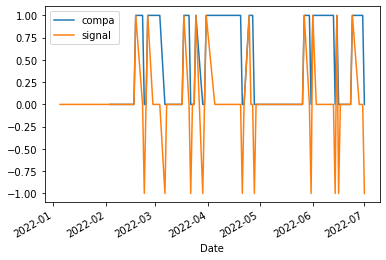

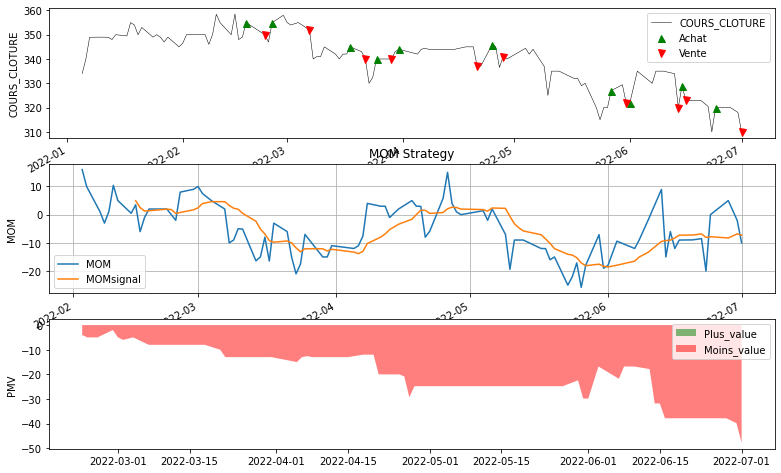

In [31]:
sign_momentum(df.Close,20,9)